In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle, gzip
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import rotate  # For image rotations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



Užkraunami duomenys

In [43]:
X, y = pickle.load(gzip.open('/content/drive/MyDrive/Flatland data/flatland_train.data', 'rb'))
X_p, y_p = pickle.load(gzip.open('/content/drive/MyDrive/Flatland data/flatland_test.data', 'rb'))

Sobel filtras, padding

In [44]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
X_p = tf.convert_to_tensor(X_p, dtype=tf.float32)

X = X / 255.0
X_p = X_p / 255.0

def apply_sobel_edges_with_padding(images, pad_width):

    padded_images = tf.pad(images, [[0, 0], [pad_width, pad_width], [pad_width, pad_width]], mode='CONSTANT')

    sobel_edges = tf.image.sobel_edges(padded_images[..., tf.newaxis])
    gradient_magnitude = tf.sqrt(tf.reduce_sum(tf.square(sobel_edges), axis=-1))

    return tf.squeeze(gradient_magnitude, axis=-1)

pad_width = 1
X_edges = apply_sobel_edges_with_padding(X, pad_width)
X_p_edges = apply_sobel_edges_with_padding(X_p, pad_width)

Kontrolei patikriname, ar viskas gerai:

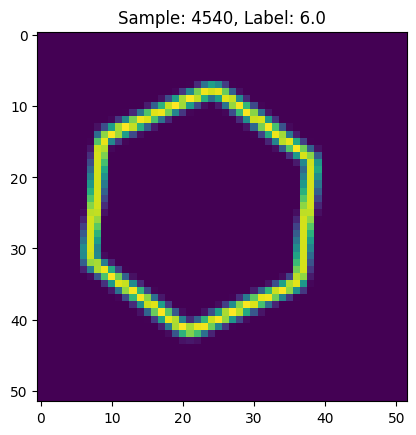

In [5]:
def plot_random_sample(X, y):
  """Plots a random sample."""

  random_index = np.random.randint(0, X.shape[0])

  sample = X[random_index]
  label = y[random_index]

  plt.imshow(sample)
  plt.title(f"Sample: {random_index}, Label: {label}")
  plt.show()

plot_random_sample(X_edges, y)

In [23]:
print(X_edges.shape)
print(X_p_edges.shape)

(10000, 52, 52)
(10000, 52, 52)


Aprašome ImageDataGenerator, kuris atsitiktine tvarka atliks vaizdų rotacijas/poslinkius/priartinimus ir t.t.

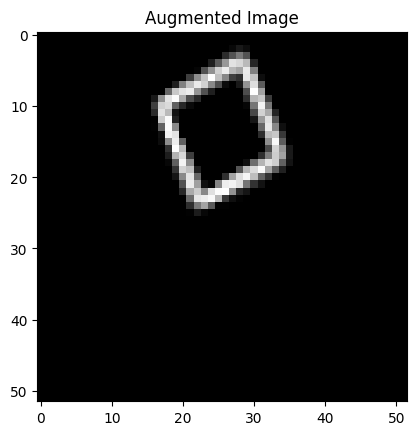

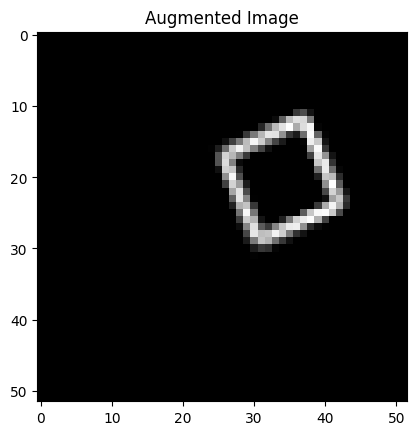

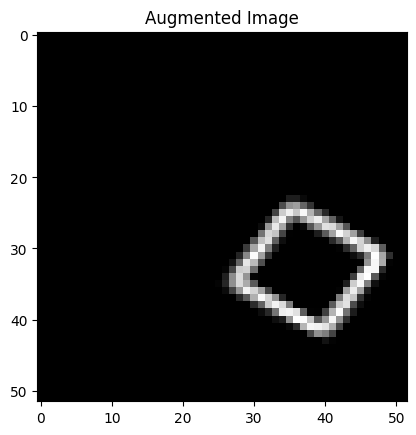

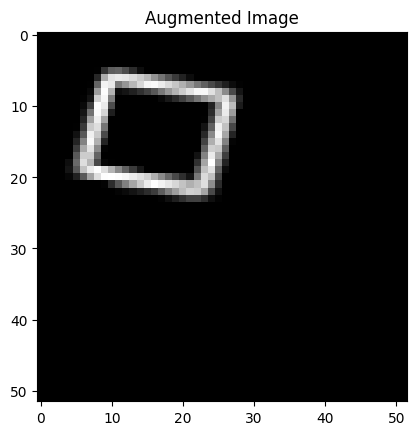

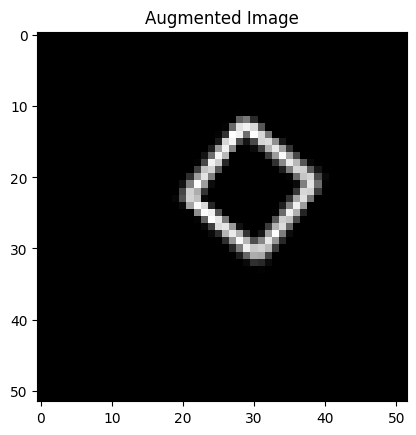

In [45]:
# add channel dimension
X_edges = np.expand_dims(X_edges, axis=-1)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


#Kontrolei patikriname ar gerai veikia:
train_datagen.fit(X_edges)

x = X_edges[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.imshow(batch[0, :, :, 0], cmap='gray')
    plt.title("Augmented Image")
    plt.show()
    i += 1
    if i >= 5:
        break


Apibrėžia neuroninį tinklą:

In [25]:
model = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(52, 52, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pridedame callbacką, kuris loggintų kaip sekasi treniruotis modeliui ir saugotų tarpinius variantus.

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='model_{epoch:02d}.weights.h5',
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=True,
    verbose=1
)

Treniruojame modelį:

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X_edges, y, test_size=0.2, random_state=42)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32,
    shuffle=True
)

model.fit(
    train_generator,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback]
)

Epoch 1/50
245/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7197 - loss: 0.7161
Epoch 1: saving model to model_01.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7198 - loss: 0.7159 - val_accuracy: 0.5605 - val_loss: 1.0599
Epoch 2/50
244/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7311 - loss: 0.7010
Epoch 2: saving model to model_02.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7314 - loss: 0.7005 - val_accuracy: 0.7815 - val_loss: 0.7013
Epoch 3/50
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7553 - loss: 0.6669
Epoch 3: saving model to model_03.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7554 - loss: 0.6664 - val_accuracy: 0.9290 - val_loss: 0.3240
Epoch 4/50
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7686 - loss: 0.6132
Epoch 4: saving model to model_04.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7686 - loss: 0.6137 - val_accuracy: 0.7825 - val_loss: 0.6033


In [33]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)


63/63 - 0s - 2ms/step - accuracy: 0.9850 - loss: 0.1317

Test accuracy: 0.9850000143051147


In [34]:
predictions = model.predict(X_p_edges)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [35]:
predicted_labels = [np.argmax(pred) for pred in predictions]
formatted_predictions = ''.join([str(round(p)) for p in predicted_labels])


In [36]:
print(formatted_predictions)

6645533343400063340545465645540463060355660333004363364366664054553303655503043350530654600355355463530403365345345040035360650004655530445455543654345046545635635636546303536656366660360305666463536336363336336465353306053566453360450054500063446060346643400453633456446546354503346300344553655053533306444055363443403030606300064655506334560544330054354500443044350645463346060306504305053645045356533336636330660644345564354536063644433663304055544504505345553050664300303444544504030306344006554333400506536544330334035643434343650403330363543435603556453440550643403430450565505303434536654355435035004453066464566036403330463456364406563043554443345350663053566660564533336350334356344353343060333043443433504546433334036630064450544503643600503355633656300553303033036463444460646453433660605604345456536403330035505464066564430553033365340544530633643635653364030035430440356634344063556033036433354560635036440504640065344340360630645656404363635646435404000566355305364003035300453665355604

In [38]:
model.save('/content/drive/MyDrive/Flatland data/my_model.keras')


In [41]:
import os
file_size = os.path.getsize('/content/drive/MyDrive/Flatland data/my_model.keras')

file_size_mb = file_size / (1024 * 1024)
print(f'Model file size: {file_size_mb:.2f} MB')

Model file size: 1.40 MB


Galutinis tikslumas: 98.48%,
Modelio dydis: 1.40MB